In [30]:
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [2]:
project_dir = '[Your Project Path]'
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [3]:
# load detected results
detected_origin_path = f'{project_dir}/checkpoints/causal-motifs-sgdet-exmp/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [46]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = prediction.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    pred_scores = prediction.get_field('pred_scores').tolist()
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    mask = pred_rel_score > thres
    pred_rel_score = pred_rel_score[mask]
    pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [64]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)

def print_list(name, input_list, scores):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()))
    
def draw_image(img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = pred_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels, None)
        print('*' * 50)
        print_list('gt_rels', gt_rels, None)
        print('*' * 50)
    print_list('pred_labels', pred_labels, pred_rel_score)
    print('*' * 50)
    print_list('pred_rels', pred_rels, pred_rel_score)
    print('*' * 50)
    
    return None

In [65]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(f'Image {cand_idx}:')
        img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label = get_info_by_idx(cand_idx, detected_origin_result)
        draw_image(img_path=img_path, boxes=boxes, labels=labels, pred_labels=pred_labels, pred_scores=pred_scores, gt_rels=gt_rels, pred_rels=pred_rels, pred_rel_score=pred_rel_score, pred_rel_label=pred_rel_label, print_img=True)

Image 100:


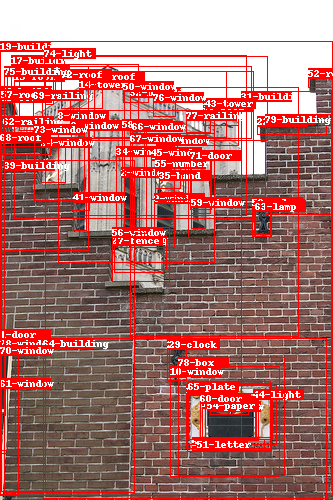

pred_labels 0: 0-roof; score: 0.8379294276237488
pred_labels 1: 1-door; score: 0.6210645437240601
pred_labels 2: 2-window; score: 0.8353006839752197
pred_labels 3: 3-building; score: 0.7802831530570984
pred_labels 4: 4-railing; score: 0.5283306837081909
pred_labels 5: 5-sign; score: 0.6657931804656982
pred_labels 6: 6-window; score: 0.6623889207839966
pred_labels 7: 7-window; score: 0.7656210064888
pred_labels 8: 8-window; score: 0.7799128890037537
pred_labels 9: 9-window; score: 0.818131685256958
pred_labels 10: 10-window; score: 0.8291050791740417
pred_labels 11: 11-basket; score: 0.8322243094444275
pred_labels 12: 12-window; score: 0.8120222687721252
pred_labels 13: 13-box; score: 0.7888745069503784
pred_labels 14: 14-tower; score: 0.5414953231811523
pred_labels 15: 15-roof; score: 0.8069856762886047
pred_labels 16: 16-pole; score: 0.5964378714561462
pred_labels 17: 17-building; score: 0.8336982131004333
pred_labels 18: 18-sign; score: 0.8105465173721313
pred_labels 19: 19-building;

In [66]:
show_all(start_idx=100, length=1)
#show_selected([119, 967, 713, 5224, 19681, 25371])